In [1]:
#Aynı anda bir den fazla zaman diliminde tarama yaparak geliştirilen strateji 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from binance import Client
client = Client()

In [3]:
def getdata(symbol, interval, start):
    frame = pd.DataFrame(client.get_historical_klines(symbol,interval,start))
    
    frame = frame[[0,1,2,3,4]]
    frame.columns = ['Date','Open','High','Low','Close']
    frame.Date = pd.to_datetime(frame.Date, unit='ms')
    frame.set_index('Date',inplace=True)
    frame = frame.astype(float)
    return frame

In [4]:
daily = getdata('ETHUSDT','1d','2022-01-01')

In [5]:
hourly = getdata('ETHUSDT','1h','2022-01-01')

In [6]:
def calc_MA(df):
    df['SMA_50'] = df.Close.rolling(50).mean()

In [7]:
calc_MA(daily)
calc_MA(hourly)

In [8]:
daily['Buy'] = daily.Close > daily.SMA_50
hourly['Buy'] = hourly.Close > hourly.SMA_50
daily['Sell'] = daily.Close < daily.SMA_50
hourly['Sell'] = hourly.Close < hourly.SMA_50

In [9]:
hourly.Buy.shift()

Date
2022-01-01 00:00:00      NaN
2022-01-01 01:00:00    False
2022-01-01 02:00:00    False
2022-01-01 03:00:00    False
2022-01-01 04:00:00    False
                       ...  
2022-10-23 15:00:00     True
2022-10-23 16:00:00     True
2022-10-23 17:00:00     True
2022-10-23 18:00:00     True
2022-10-23 19:00:00     True
Name: Buy, Length: 7100, dtype: object

In [10]:
hourly.Buy = hourly.Buy.shift().fillna(False)
daily.Buy = daily.Buy.shift().fillna(False)
hourly.Sell = hourly.Buy.shift().fillna(False)
daily.Sell = daily.Buy.shift().fillna(False)

In [11]:
position = False 
buydates,selldates = [],[]

for index_daily, row_daily in daily.iterrows():
    if not position and row_daily['Buy']:
        for index_hourly, row_hourly in hourly[index_daily : ][1:25].iterrows():
            if not position and row_hourly['Buy']:
                position= True 
                buydates.append(index_hourly)
                
    if position and row_daily['Sell']:
        for index_hourly,row_hourly in hourly[index_daily:][1:25].iterrows():
             if position and row_hourly['Sell']:
                position= False
                selldates.append(index_hourly)
            

In [12]:
daily['2022-01-01': ]

,Open,High,Low,Close,SMA_50,Buy,Sell
Date,,,,,,,
2022-01-01,3676.22,3776.45,3673.46,3765.54,NaN,False,False
2022-01-02,3765.54,3857.44,3717.30,3828.27,NaN,False,False
2022-01-03,3828.11,3853.09,3680.00,3765.89,NaN,False,False
2022-01-04,3765.89,3900.73,3713.11,3785.11,NaN,False,False
2022-01-05,3785.10,3848.00,3415.00,3540.63,NaN,False,False
...,...,...,...,...,...,...,...
2022-10-19,1310.71,1313.50,1280.31,1285.09,1419.4234,False,False
2022-10-20,1285.09,1310.87,1270.36,1282.57,1413.9928,False,False
2022-10-21,1282.57,1306.97,1252.65,1299.75,1408.2646,False,False


In [13]:
hourly['2022-01-01': ]

,Open,High,Low,Close,SMA_50,Buy,Sell
Date,,,,,,,
2022-01-01 00:00:00,3676.22,3730.00,3676.22,3723.04,NaN,False,False
2022-01-01 01:00:00,3723.04,3748.45,3714.10,3724.89,NaN,False,False
2022-01-01 02:00:00,3724.88,3738.47,3722.23,3728.32,NaN,False,False
2022-01-01 03:00:00,3728.41,3737.00,3721.84,3723.96,NaN,False,False
2022-01-01 04:00:00,3723.96,3728.07,3707.24,3708.21,NaN,False,False
...,...,...,...,...,...,...,...
2022-10-23 15:00:00,1311.16,1316.50,1311.16,1313.60,1305.8568,True,True
2022-10-23 16:00:00,1313.60,1314.87,1311.19,1312.44,1306.5124,True,True
2022-10-23 17:00:00,1312.45,1330.88,1311.56,1328.69,1307.1368,True,True


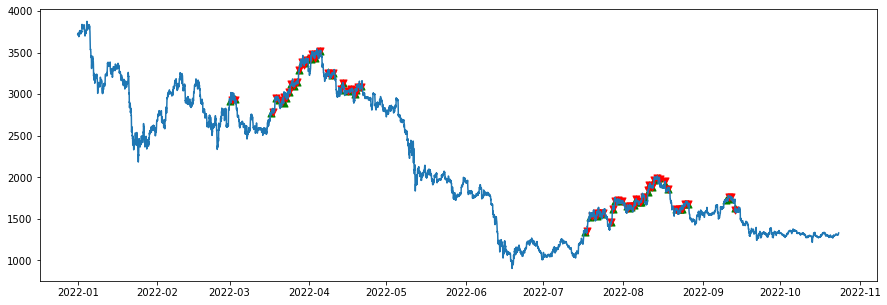

In [14]:
plt.figure(figsize=(15,5))
plt.plot(hourly.Close)
plt.scatter(hourly.loc[buydates].index, hourly.loc[buydates].Close, marker='^',c='g',s=50)
plt.scatter(hourly.loc[selldates].index, hourly.loc[selldates].Close, marker='v',c='r',s=50)

In [15]:
buy_arr = hourly.loc[buydates].Open

In [16]:
sell_arr = hourly.loc[selldates].Open

In [17]:
buy_arr = buy_arr[:len(sell_arr)]

In [18]:
buy_arr

Date
2022-03-01 01:00:00    2947.68
2022-03-03 01:00:00    2965.47
2022-03-17 01:00:00    2767.85
2022-03-19 01:00:00    2966.14
2022-03-20 01:00:00    2939.48
                        ...   
2022-08-25 01:00:00    1668.90
2022-08-26 01:00:00    1675.26
2022-09-10 01:00:00    1717.00
2022-09-12 02:00:00    1761.61
2022-09-13 12:00:00    1737.64
Name: Open, Length: 68, dtype: float64

In [19]:
sell_arr

Date
2022-03-02 01:00:00    2943.92
2022-03-03 02:00:00    2946.16
2022-03-18 01:00:00    2775.07
2022-03-19 01:00:00    2966.14
2022-03-20 01:00:00    2939.48
                        ...   
2022-08-25 01:00:00    1668.90
2022-08-26 01:00:00    1675.26
2022-09-11 01:00:00    1772.10
2022-09-12 01:00:00    1735.57
2022-09-13 13:00:00    1628.68
Name: Open, Length: 68, dtype: float64

In [20]:
profit = (sell_arr.values - buy_arr.values) / buy_arr.values

In [21]:
profit

array([-0.00127558, -0.00651162,  0.00260852,  0.        ,  0.        ,
       -0.00069361, -0.00185271,  0.        ,  0.        ,  0.        ,
       -0.00524401,  0.        ,  0.        ,  0.        , -0.00339528,
        0.00640969,  0.02175438,  0.        ,  0.        , -0.00283436,
        0.        ,  0.00159696, -0.00249282,  0.        ,  0.00096844,
        0.        , -0.00095248,  0.        , -0.00288613,  0.        ,
        0.        ,  0.00474433, -0.01099385, -0.02398503, -0.01420083,
        0.        ,  0.00947779, -0.00267716,  0.00675769,  0.        ,
        0.        ,  0.        ,  0.00131679, -0.01081126, -0.00311473,
        0.00518135,  0.00875462,  0.        , -0.00020493, -0.00361345,
        0.        ,  0.00329128,  0.        ,  0.        ,  0.        ,
        0.        , -0.00691445,  0.01268627, -0.01299869, -0.00172461,
       -0.00885729,  0.        ,  0.        ,  0.        ,  0.        ,
        0.03209086, -0.01478193, -0.06270574])

In [22]:
profit.mean()

-0.001295346768566516

In [23]:
(profit +1).prod() - 1

-0.08785816410056058